In [26]:
import tensorflow as tf 

In [27]:
# You can create constants in TF to hold specific values
a = tf.constant(1)
b = tf.constant(2)

In [28]:
# Of course you can add, multiply and compute on these as you like
c = a + b 
d = a * b

In [29]:
# TF numbers are stored in "tensors", a fancy term for multidimensional arrays. If you pass TF a Python list, it can convert it.
V1 = tf.constant([1.0, 2.0]) # Vector, 1-dimensional
V2 = tf.constant([3.0, 4.0]) # Vector, 1-dimensional
M = tf.constant([[1.0, 2.0]]) # Matrix, 2d
N = tf.constant([[1.0, 2.0], [3.0, 4.0]]) # Matrix, 2d
K = tf.constant([[[1.0, 2.0],[3.0, 4.0]]]) # Matrix, 3d

In [30]:
# You can also compute on tensors like you did scalars, but be careful of shape
V3 = V1 + V2

In [31]:
# Operations are element-wise by default
M2 = M * M 

In [32]:
# True matrix mutiplicatin requires a special call
NN = tf.matmul(N,N)

In [33]:
# The above code only defines a TF "graph", Nothing has been computed yet. For that, you first need to create a TF "session".
sess = tf.Session()

# Note the parallelism information TF reports to you when starting a session

In [34]:
# Now you can run specific nodes of your graph, i.e. the variables you've named
output = sess.run(NN)
print "NN is: \n", output 

NN is: 
[[  7.  10.]
 [ 15.  22.]]


In [35]:
# Remember to close your session when you are done using it
sess.close()

In [36]:
# Often, we work interactively, it's convenient to use a simplified session
sess = tf.InteractiveSession()

In [37]:
# Now we can compute any node
print "M2 is: ", M2.eval()

M2 is:  [[ 1.  4.]]


In [38]:
# TF "variables" can change value, useful for updating model weights.
W = tf.Variable(0, name="weight")

In [39]:
# But variables must be initialized by TF before use
init_op = tf.initialize_all_variables()
sess.run(init_op)

print "W is: \n", W.eval()

W is: 
0


In [40]:
W += a
print "W after adding a: \n", W.eval()

W after adding a: 
1


In [41]:
W += a
print "W after adding a again: \n", W.eval()

W after adding a again: 
2


In [42]:
# You can return or supply arbitrary nodes, i.e. check an intermediate value or sub your value in the middle of the computation
E = d + b # 1 * 2 + 2 = 4

print "E as defined: ", E.eval()

E as defined:  4


In [43]:
# Let's see what d was at the same time
print "E and d: ", sess.run([E,d])

E and d:  [4, 2]


In [45]:
# Use a custom d by specifying a dictionary
print "E with custom d=4:", sess.run(E, feed_dict={d:4.})

 E with custom d=4: 6


### Logistic Regression Model Building

In [46]:
import tensorflow as tf
import numpy as np
% matplotlib inline

try:
    from tqdm import tqdm
except:
    def tqdm(x, *args, **kwargs):
        return x

In [47]:
# Set random seed
np.random.seed(0)

In [51]:
# Load data 
data = np.load("data_with_labels.npz")
train = data["arr_0"] / 255.
labels = data["arr_1"]

# Look at some data
print train[0]
print labels[0]

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
0


In [53]:
import matplotlib.pyplot as plt 
plt.ion()

# Let's look at a subplot of one of A in each font
plt.figure(figsize=(6,6))
f, plts = plt.subplots(5, sharex=True)
c =91
for i in range(5):
    plts[i].pcolor(train[c + i*558], cmap=plt.cm.gray_r)

In [55]:
def to_onehot(labels, nclasses = 5):
    outlabels = np.zeros((len(labels), nclasses))
    for i, l in enumerate(labels):
        outlabels[i,l] = 1
    return outlabels

onehot = to_onehot(labels)

In [57]:
# Split data into trainig and validation
indices = np.random.permutation(train.shape[0])
valid_cnt = int(train.shape[0] * 0.1)
test_idx, training_idx = indices[:valid_cnt], indices[valid_cnt:]
test, train = train[test_idx,:], train[training_idx,:]
onehot_test, onehot_train = onehot[test_idx,:], onehot[training_idx,:]

sess = tf.InteractiveSession()

Exception AssertionError: AssertionError("Nesting violated for default stack of <type 'weakref'> objects",) in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x10d0e8b50>> ignored


In [59]:
# These will be inputs, and inputs pixels, flattened
x = tf.placeholder("float", [None, 1296])

# Known labels
y_ = tf.placeholder("float", [None, 5])

# Variables
W = tf.Variable(tf.zeros([1296, 5]))
b = tf.Variable(tf.zeros([5]))

In [60]:
# Just Initialize
sess.run(tf.initialize_all_variables())

In [61]:
# Define model 
y = tf.nn.softmax(tf.matmul(x,W) + b) 

In [64]:
### End model specification, begin training code
# Climb on cross-entropy

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y+1e-50, y_))

# How we train
train_step = tf.train.GradientDescentOptimizer(0.02).minimize(cross_entropy)

# Define accuracy 
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

# Actually train 
epochs = 1000
train_acc = np.zeros(epochs//10)
test_acc = np.zeros(epochs//10)

for i in tqdm(range(epochs)):
    # Record summary data, and the accuracy 
    if i % 10 == 0:
        # Check accuracy on train set
        A = accuracy.eval(feed_dict={x:train.reshape([-1, 1296]), y_: onehot_train})
        train_acc[i//10] = A
        
        # And now the validation set 
        A = accuracy.eval(feed_dict={x:test.reshape([-1, 1296]), y_: onehot_test})
        test_acc[i//10] = A
    train_step.run(feed_dict={x:train.reshape([-1,1296]), y_: onehot_train})

# Notice that accuracy flattens out
print train_acc[-1]
print test_acc[-1]

0.298230081797
0.211155384779


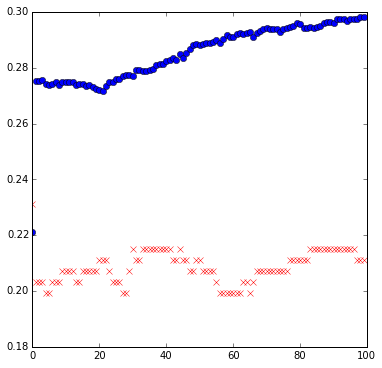

/Users/AkiraKaneshiro/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


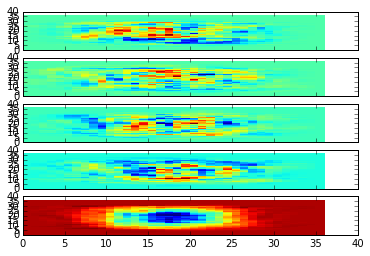

In [65]:
%matplotlib inline
# Plot the accuracy curves
plt.figure(figsize=(6,6))
plt.plot(train_acc, "bo")
plt.plot(test_acc, "rx")

# Look at a subplot of the weights for each font
plt.figure(figsize=(6,6))
f, plts = plt.subplots(5, sharex=True)
for i in range(5):
    plts[i].pcolor(W.eval()[:,i].reshape([36,36]))

### Basic Neural Nets

In [66]:
import tensorflow as tf
import numpy as np
import math

sess = tf.InteractiveSession()

Exception AssertionError: AssertionError("Nesting violated for default stack of <type 'weakref'> objects",) in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x10d0f3cd0>> ignored


In [68]:
# Some simple constants
x1 = tf.Variable(tf.truncated_normal([5], mean=3, stddev=1./math.sqrt(5)))
x2 = tf.Variable(tf.truncated_normal([5], mean=-1, stddev=1./math.sqrt(5)))
x3 = tf.Variable(tf.truncated_normal([5], mean=0, stddev=1./math.sqrt(5)))

sess.run(tf.initialize_all_variables())

# Squaring makes large values extreme (but positive). Be careful if you have negative values
sqx2 = x2 * x2
print x2.eval()
print sqx2.eval()

[-0.14887375 -1.02016234 -1.06843162 -1.04658628 -0.41900158]
[ 0.02216339  1.04073119  1.14154613  1.09534287  0.17556232]


In [69]:
# Logarithm makes small values more pronouced (and negative). be careful that your algorithm can handle negative numbers
logx1 = tf.log(x1)
print x1.eval()
print logx1.eval()

[ 3.19382405  3.01717424  3.30711412  2.51774788  2.71740389]
[ 1.161219    1.10432076  1.19607592  0.92336482  0.99967694]


In [70]:
# Sigmoid is a common transformation in deep learnig. Extreme values get flattened to +1 or 0. Input closer to zero stay similar, sigmoid(0)=0.5
sigx3 = tf.sigmoid(x3)
print x3.eval()
print sigx3.eval()

[ 0.56187254  0.23261295  0.61573344 -0.16041182 -0.45613125]
[ 0.6368857   0.55789244  0.64924753  0.45998281  0.38790402]


In [73]:
# We linearly combine multiple inputs, then transform
w1 = tf.constant(0.1)
w2 = tf.constant(0.2)
sess.run(tf.initialize_all_variables())
n1 = tf.sigmoid(w1*x1 + w2*x2)
print (w1*x1).eval()
print (w2*x2).eval()
print n1.eval()

[ 0.32685003  0.3368319   0.2531409   0.2501061   0.27555615]
[-0.3527613  -0.29386708 -0.24080987 -0.11619806 -0.25711676]
[ 0.49352255  0.51073956  0.50308269  0.53342706  0.50460976]


### Single Hidden Layer Model

In [75]:
import tensorflow as tf
import numpy as np
import math
try:
    from tqdm import tqdm
except:
    def tqdm(x, *args, **kwargs):
        return x
    
# Set random seed
np.random.seed(0)

# Load data 
data = np.load("data_with_labels.npz")
train = data["arr_0"] / 255.
labels = data["arr_1"]

# Look at some data
print train[0]
print labels[0]

import matplotlib.pyplot as plt 
plt.ion()

def to_onehot(labels, nclasses = 5):
    outlabels = np.zeros((len(labels), nclasses))
    for i, l in enumerate(labels):
        outlabels[i,l] = 1
    return outlabels

onehot = to_onehot(labels)

# Split data into trainig and validation
indices = np.random.permutation(train.shape[0])
valid_cnt = int(train.shape[0] * 0.1)
test_idx, training_idx = indices[:valid_cnt], indices[valid_cnt:]
test, train = train[test_idx,:], train[training_idx,:]
onehot_test, onehot_train = onehot[test_idx,:], onehot[training_idx,:]

sess = tf.InteractiveSession()

# These will be inputs, and inputs pixels, flattened
x = tf.placeholder("float", [None, 1296])

# Known labels
y_ = tf.placeholder("float", [None, 5])

# Hidden layer
num_hidden = 128
W1 = tf.Variable(tf.truncated_normal([1296,num_hidden], stddev=1./math.sqrt(1296)))
b1 = tf.Variable(tf.constant(0.1, shape=[num_hidden]))
h1 = tf.sigmoid(tf.matmul(x,W1) + b1)

# Output Layer
W2 = tf.Variable(tf.truncated_normal([num_hidden, 5], stddev=1./math.sqrt(5)))
b2 = tf.Variable(tf.constant(0.1, shape=[5]))

# Just Initialize
sess.run(tf.initialize_all_variables())

# Define model
y = tf.nn.softmax(tf.matmul(h1,W2)+b2)

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
0


Exception AssertionError: AssertionError("Nesting violated for default stack of <type 'weakref'> objects",) in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x115db6ed0>> ignored


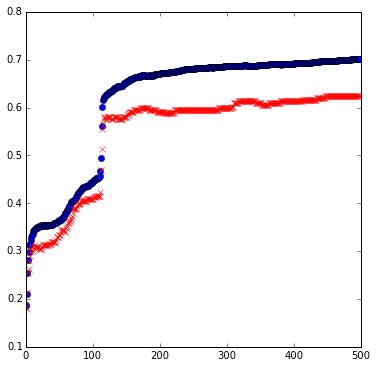

In [76]:
### End model specification, begin training code 
# Climb on cross-entropy
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y+1e-50, y_))

# How we train
train_step = tf.train.GradientDescentOptimizer(0.02).minimize(cross_entropy)

# Define accuracy 
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
 
# Actually train 
epochs = 5000
train_acc = np.zeros(epochs//10)
test_acc = np.zeros(epochs//10)

for i in tqdm(range(epochs)):
    # Record summary data, and the accuracy 
    if i % 10 == 0:
        # Check accuracy on train set
        A = accuracy.eval(feed_dict={x:train.reshape([-1, 1296]), y_: onehot_train})
        train_acc[i//10] = A
        
        # And now the validation set 
        A = accuracy.eval(feed_dict={x:test.reshape([-1, 1296]), y_: onehot_test})
        test_acc[i//10] = A
    train_step.run(feed_dict={x:train.reshape([-1,1296]), y_: onehot_train})

# Plot the accuracy curves
plt.figure(figsize=(6,6))
plt.plot(train_acc, "bo")
plt.plot(test_acc, "rx")  

<matplotlib.colorbar.Colorbar instance at 0x1181ff638>

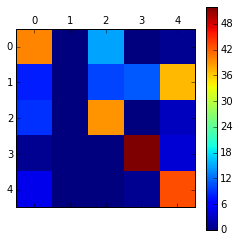

In [77]:
# Look at the final testing confusion matrix
pred = np.argmax(y.eval(feed_dict={x:test.reshape([-1,1296]), y_:onehot_test}), axis=1)
conf = np.zeros([5,5])
for p, t in zip(pred, np.argmax(onehot_test, axis=1)):
    conf[t,p] += 1

plt.matshow(conf)
plt.colorbar()

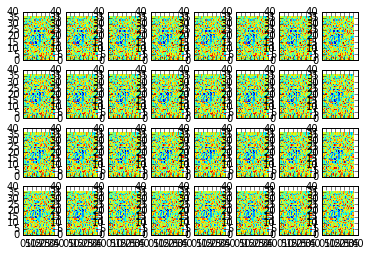

In [79]:
# Let's look at a subplot of some weights
plt.figure(figsize=(6,6))
f, plts = plt.subplots(4,8, sharex=True)
for i in range(32):
    plts[i//8, i%8].pcolormesh(W1.eval()[:,1].reshape([36,36]))

### Multiple Hidden Layer Model

In [80]:
import tensorflow as tf
import numpy as np
import math
try:
    from tqdm import tqdm
except:
    def tqdm(x, *args, **kwargs):
        return x
    
# Set random seed
np.random.seed(0)

# Load data 
data = np.load("data_with_labels.npz")
train = data["arr_0"] / 255.
labels = data["arr_1"]

# Look at some data
print train[0]
print labels[0]

import matplotlib.pyplot as plt 
plt.ion()

def to_onehot(labels, nclasses = 5):
    outlabels = np.zeros((len(labels), nclasses))
    for i, l in enumerate(labels):
        outlabels[i,l] = 1
    return outlabels

onehot = to_onehot(labels)

# Split data into trainig and validation
indices = np.random.permutation(train.shape[0])
valid_cnt = int(train.shape[0] * 0.1)
test_idx, training_idx = indices[:valid_cnt], indices[valid_cnt:]
test, train = train[test_idx,:], train[training_idx,:]
onehot_test, onehot_train = onehot[test_idx,:], onehot[training_idx,:]

sess = tf.InteractiveSession()

# These will be inputs, and inputs pixels, flattened
x = tf.placeholder("float", [None, 1296])

# Known labels
y_ = tf.placeholder("float", [None, 5])

# Hidden layer 1
num_hidden1 = 128
W1 = tf.Variable(tf.truncated_normal([1296,num_hidden1], stddev=1./math.sqrt(1296)))
b1 = tf.Variable(tf.constant(0.1, shape=[num_hidden1]))
h1 = tf.sigmoid(tf.matmul(x,W1) + b1)

# Hidden Layer 2
num_hidden2 = 32
W2 = tf.Variable(tf.truncated_normal([num_hidden1, num_hidden2], stddev= 2./math.sqrt(num_hidden1)))
b2 = tf.Variable(tf.constant(0.2, shape=[num_hidden2]))
h2 = tf.sigmoid(tf.matmul(h1,W2) + b2)

# Output Layer
W3 = tf.Variable(tf.truncated_normal([num_hidden2, 5], stddev=1./math.sqrt(5)))
b3 = tf.Variable(tf.constant(0.1, shape=[5]))

# Just Initialize
sess.run(tf.initialize_all_variables())

# Define model
y = tf.nn.softmax(tf.matmul(h2,W3)+b3)

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
0


Exception AssertionError: AssertionError("Nesting violated for default stack of <type 'weakref'> objects",) in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x115da8a50>> ignored


In [ ]:
### End model specification, begin training code 
# Climb on cross-entropy
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y+1e-50, y_))

# How we train
train_step = tf.train.GradientDescentOptimizer(0.02).minimize(cross_entropy)

# Define accuracy 
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
 
# Actually train 
epochs = 25000
train_acc = np.zeros(epochs//10)
test_acc = np.zeros(epochs//10)

for i in tqdm(range(epochs)):
    # Record summary data, and the accuracy 
    if i % 10 == 0:
        # Check accuracy on train set
        A = accuracy.eval(feed_dict={x:train.reshape([-1, 1296]), y_: onehot_train})
        train_acc[i//10] = A
        
        # And now the validation set 
        A = accuracy.eval(feed_dict={x:test.reshape([-1, 1296]), y_: onehot_test})
        test_acc[i//10] = A
    train_step.run(feed_dict={x:train.reshape([-1,1296]), y_: onehot_train})

# Plot the accuracy curves
plt.figure(figsize=(6,6))
plt.plot(train_acc, "bo")
plt.plot(test_acc, "rx") 

# Look at the final testing confusion matrix
pred = np.argmax(y.eval(feed_dict={x:test.reshape([-1,1296]), y_:onehot_test}), axis=1)
conf = np.zeros([5,5])
for p, t in zip(pred, np.argmax(onehot_test, axis=1)):
    conf[t,p] += 1

plt.matshow(conf)
plt.colorbar()

# Let's look at a subplot of some weights
plt.figure(figsize=(6,6))
f, plts = plt.subplots(4,8, sharex=True)
for i in range(32):
    plts[i//8, i%8].pcolormesh(W1.eval()[:,1].reshape([36,36]))
    
# Examine the output weights
plt.matshow(W3.eval()) 
plt.colorbar()

# Save the weights
saver = tf.train.Saver()
saver.save(sess, "mpl.ckpt")

# Restore
saver.store(sess. "mpl.ckpt")

### Convolutional Neural Networks

In [81]:
import tensorflow as tf
import math
import numpy as np

sess = tf.InteractiveSession()

# Make some fake data, 1 data points
image = np.random.randint(10, size=[1,10,10]) + np.eye(10)*10

# TensorFlow placeholer, None is for batch processing, -1 keeps same size, 10*10 is the shape, 1 is the number of "channels", like RGB coloes or Gray 
x = tf.placeholder("float",[None, 10, 10])
x_im = tf.reshape(x, [-1, 10, 10, 1])

Exception AssertionError: AssertionError("Nesting violated for default stack of <type 'weakref'> objects",) in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x116cf3f90>> ignored


<matplotlib.colorbar.Colorbar instance at 0x1188377e8>

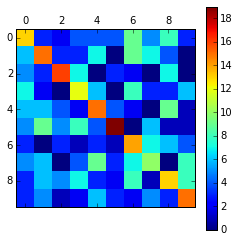

In [83]:
### Convolutional Layer
# Window size to use, 3*3 here
winx = 3
winy = 3

# How mnay features ro compute on the window
num_filters = 2 

# Weight shape should match window size, the "1" represents the number of input "channels" (colors)
W1 = tf.Variable(tf.truncated_normal([winx, winy, 1, num_filters], stddev = 1./math.sqrt(winx*winy)))
b1 = tf.Variable(tf.constant(0.1, shape=[num_filters]))

# 3*3 convolution, Pad with zeros on edges.
# Strides is how to step, here 1 pixel at a time
xw = tf.nn.conv2d(x_im, W1, strides=[1,1,1,1], padding="SAME")
h1 = tf.nn.relu(xw+b1)

# Remember to initialize!
sess.run(tf.initialize_all_variables())

# Peek inside
H = h1.eval(feed_dict={x:image})

# Let's take a look
import matplotlib.pyplot as plt
plt.ion()

# Original
plt.matshow(image[0])
plt.colorbar()

<function matplotlib.pyplot.colorbar>

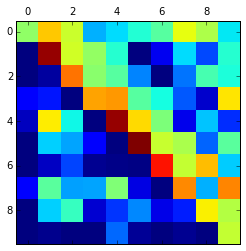

In [84]:
# Conv channel 1
plt.matshow(H[0,:,:,0])
plt.colorbar

<function matplotlib.pyplot.colorbar>

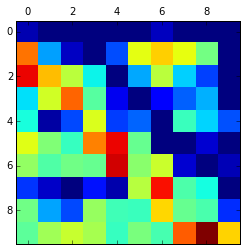

In [85]:
# Conv channel 2
plt.matshow(H[0,:,:,1])
plt.colorbar

<matplotlib.colorbar.Colorbar instance at 0x1146795f0>

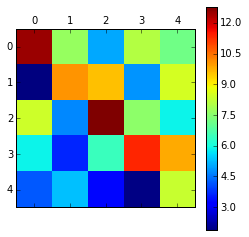

In [86]:
### Pooling Layer
# "Max" pooling keeps best of 2*2 square in h1 output, ksize defines size of this block
# "VALID" padding means incomplete squares are not used, Stride of 2*2 means no overlap of 2*2 blocks
p1 = tf.nn.max_pool(h1, ksize=[1,2,2,1], strides=[1,2,2,1], padding="VALID")

# We automatically determine the size
p1_size = np.product([s.value for s in p1.get_shape()[1:]])

# Need to flatten convolutional output for use in a dense layer, -1 chooses appropriate shape to keep overall size the same.
p1f = tf.reshape(p1, [-1,p1_size])

# Pooling Layer before flattening. Note how it's only 5*5, because we took the best of every 2*2 window
P = p1.eval(feed_dict={x:image})
plt.matshow(P[0,:,:,0])
plt.colorbar()

### Deep CNN

In [87]:
import tensorflow as tf
import numpy as np
import math
try:
    from tqdm import tqdm
except:
    def tqdm(x, *args, **kwargs):
        return x
    
# Set random seed
np.random.seed(0)

# Load data 
data = np.load("data_with_labels.npz")
train = data["arr_0"] / 255.
labels = data["arr_1"]

# Look at some data
print train[0]
print labels[0]

import matplotlib.pyplot as plt 
plt.ion()

def to_onehot(labels, nclasses = 5):
    outlabels = np.zeros((len(labels), nclasses))
    for i, l in enumerate(labels):
        outlabels[i,l] = 1
    return outlabels

onehot = to_onehot(labels)

# Split data into trainig and validation
indices = np.random.permutation(train.shape[0])
valid_cnt = int(train.shape[0] * 0.1)
test_idx, training_idx = indices[:valid_cnt], indices[valid_cnt:]
test, train = train[test_idx,:], train[training_idx,:]
onehot_test, onehot_train = onehot[test_idx,:], onehot[training_idx,:]

sess = tf.InteractiveSession()

# There will be inputs
## Input pixals, image with one channel (gray)
x = tf.placeholder("float",[None, 36, 36])
# Note that -1 is for reshaping
x_im = tf.reshape(x, [-1, 36, 36, 1])
## Known labels. None works during variable creation to be specified size
y_ = tf.placeholder("float",[None,5])

# Avoid numberical precision problems

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
0


Exception AssertionError: AssertionError("Nesting violated for default stack of <type 'weakref'> objects",) in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x114187ed0>> ignored


In [88]:
# Conv layer 1
num_filters = 4
winx = 5
winy = 5
W1 = tf.Variable(tf.truncated_normal([winx, winy, 1, num_filters], stddev=1./math.sqrt(winx*winy)))
b1 = tf.Variable(tf.constant(0.1, shape=[num_filters]))

# 5*5 convolution, pad with zeros on edges
xw = tf.nn.conv2d(x_im, W1, strides=[1,1,1,1], padding="SAME")
h1 = tf.nn.relu(xw+b1)

# 2*2 Max pooling, no padding o edges
p1 = tf.nn.max_pool(h1, ksize=[1,2,2,1], strides=[1,2,2,1], padding="VALID")

# Need to flatten convolutional output for use in dense layer.
p1_size = np.product([s.value for s in p1.get_shape()[1:]])
p1f = tf.reshape(p1, [-1, p1_size])

In [89]:
# Dense layer
num_hidden = 32
W2 = tf.Variable(tf.truncated_normal([p1_size, num_hidden], stddev=2./math.sqrt(p1_size)))
b2 = tf.Variable(tf.constant(0.2, shape=[num_hidden]))
h2 = tf.nn.relu(tf.matmul(p1f,W2) + b2)

# Ouput layer 
W3 = tf.Variable(tf.truncated_normal([num_hidden,5], stddev=1./math.sqrt(num_hidden)))
b3 = tf.Variable(tf.constant(0.1, shape=[5]))

keep_prob = tf.placeholder("float")
h2_drop = tf.nn.dropout(h2,keep_prob)

# Just initialize
sess.run(tf.initialize_all_variables())

# Define model
y = tf.nn.softmax(tf.matmul(h2_drop, W3) + b3)

### End model specification, begin training code

In [ ]:
# Climb on cross entropy
cross_entropy = tf.reduce_mean(tf.nn.softmax.cross_entropy_with_logits(y+1e-50, y_))

# How we train
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

# Define accuracy
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction,"float"))

# Actually train 
epochs = 5000
train_acc = np.zeros(epochs//10)
test_acc = np.zeros(epochs//10)
for i in tqdm(range(epochs), ascii=True):
    # Record summary data, and the accuracy
    if i % 10 == 0:
        # check accuracy on train set
        A = accuracy.eval(feed_dict={x:train, y_: onehot_train, keep_prob=1.0})
        train_acc[i//10] = A
        # and now the validation set
        A = accuracy.eval(feed_dict={x:test, y_:onehot_test, keep_prob=1.0})
        test_acc[i//10] = A
    train_step.run(feed_dict={x:train, y_:onehot_train, keep_prob=0.5})

# Plot the accuracy curves
plt.figure = (figsize=(6,6))
plt.plot(train_acc, "bo")
plt.plot(test_acc, "rx")

# Look at the final testing confusion matrix
pred = np.argmax(y.eval(feed_dict={x:test, keep_prob:1.0, y_:onehot_test}), axis=1)
conf = np.zeros([5,5])
for p, t in zip(pred, np.argmax(onehot_test, axis=1)):
    conf[t,p] += 1

plt.matshow(conf)
plt.colorbar()

# Let's look at a subplot of some weights
f, plts = plt.subplots(4)
for i in range(4):
    plts[i].matshow(W1.eval()[:,:,0,i])

# Examine the output weights
plt.matshow(W3.eval())
plt.colorbar()

# Save the weights
saver = tf.train.Saver()
saver.save(sess,"conv1.ckpt")

# Restore
saver.load(sess, "conv1.ckpt")

# Or use Numpy manually
def save_all(name="conv1"):
    np.savez.compressed(name, W1.eval(), b1.eval(), W2.eval(), b2.eval(), W3.eval(), b3.eval())

save_all()

def load_all(name = "conv1.npz"):
    data = np.load(name)
    sess.run(W1.assign(data["arr_0"]))
    sess.run(b1.assign(data["arr_1"]))
    sess.run(W2.assign(data["arr_2"]))
    sess.run(b2.assign(data["arr_3"]))
    sess.run(W3.assign(data["arr_4"]))
    sess.run(b3.assign(data["arr_5"]))
    
load_all()

### Deeper CNN

In [90]:
import tensorflow as tf
import numpy as np
import math
try:
    from tqdm import tqdm
except:
    def tqdm(x, *args, **kwargs):
        return x
    
# Set random seed
np.random.seed(0)

# Load data 
data = np.load("data_with_labels.npz")
train = data["arr_0"] / 255.
labels = data["arr_1"]

# Look at some data
print train[0]
print labels[0]

import matplotlib.pyplot as plt 
plt.ion()

def to_onehot(labels, nclasses = 5):
    outlabels = np.zeros((len(labels), nclasses))
    for i, l in enumerate(labels):
        outlabels[i,l] = 1
    return outlabels

onehot = to_onehot(labels)

# Split data into trainig and validation
indices = np.random.permutation(train.shape[0])
valid_cnt = int(train.shape[0] * 0.1)
test_idx, training_idx = indices[:valid_cnt], indices[valid_cnt:]
test, train = train[test_idx,:], train[training_idx,:]
onehot_test, onehot_train = onehot[test_idx,:], onehot[training_idx,:]

sess = tf.InteractiveSession()

# There will be inputs
## Input pixals, image with one channel (gray)
x = tf.placeholder("float",[None, 36, 36])
# Note that -1 is for reshaping
x_im = tf.reshape(x, [-1, 36, 36, 1])
## Known labels. None works during variable creation to be specified size
y_ = tf.placeholder("float",[None,5])

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
0


Exception AssertionError: AssertionError("Nesting violated for default stack of <type 'weakref'> objects",) in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x117d24250>> ignored


In [92]:
# Conv layer 1
num_filters1 = 16
winx1 = 3
winy1 = 3
W1 = tf.Variable(tf.truncated_normal([winx1, winy1, 1, num_filters1], stddev=1./math.sqrt(winx1*winy1)))
b1 = tf.Variable(tf.constant(0.1, shape=[num_filters1]))

# 3*3 convolution, pad with zeros on edges
xw = tf.nn.conv2d(x_im, W1, strides=[1,1,1,1], padding="SAME")
h1 = tf.nn.relu(xw + b1)

# 2*2 Max pooling, no padding on egdes
p1 = tf.nn.max_pool(h1, ksize=[1,2,2,1], strides=[1,2,2,1], padding="VALID")

In [94]:
# Conv layer 2
num_filters2 = 4
winx2 = 3
winy2 = 3
W2 = tf.Variable(tf.truncated_normal([winx2, winy2, num_filters1, num_filters2], stddev=1./math.sqrt(winx2*winy2)))
b2 = tf.Variable(tf.constant(0.1, shape=[num_filters2]))

# 3*3 convolution, pad with zeros on edges
plw2 = tf.nn.conv2d(p1, W2, strides=[1,1,1,1], padding="SAME")
h1 = tf.nn.relu(plw2 + b2)

# 2*2 Max pooling, no padding on edges
p2 = tf.nn.max_pool(h1, ksize=[1,2,2,1], strides=[1,2,2,1], padding="VALID")

# Need to flatten convolutional output
p2_size = np.product([s.value for s in p2.get_shape()[1:]])
p2f = tf.reshape(p2, [-1, p2_size])

In [95]:
# Dense layer
num_hidden = 32
W3 = tf.Variable(tf.truncated_normal([p2_size, num_hidden], stddev=2./math.sqrt(p2_size)))
b3 = tf.Variable(tf.constant(0.2, shape=[num_hidden]))
h3 = tf.nn.relu(tf.matmul(p2f,W3) + b3)

# Drop out training
keep_prob = tf.placeholder("float")
h3_drop = tf.nn.dropout(h3,keep_prob)

# Ouput layer 
W4 = tf.Variable(tf.truncated_normal([num_hidden,5], stddev=1./math.sqrt(num_hidden)))
b4 = tf.Variable(tf.constant(0.1, shape=[5]))

# Just initialize
sess.run(tf.initialize_all_variables())

# Define model
y = tf.nn.softmax(tf.matmul(h3_drop, W4) + b4)

### End model specification, begin training code

In [ ]:
# Climb on cross entropy
cross_entropy = tf.reduce_mean(tf.nn.softmax.cross_entropy_with_logits(y+1e-50, y_))

# How we train
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

# Define accuracy
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction,"float"))

# Actually train 
epochs = 6000
train_acc = np.zeros(epochs//10)
test_acc = np.zeros(epochs//10)
for i in tqdm(range(epochs), ascii=True):
    # Record summary data, and the accuracy
    if i % 10 == 0:
        # check accuracy on train set
        A = accuracy.eval(feed_dict={x:train, y_: onehot_train, keep_prob=1.0})
        train_acc[i//10] = A
        # and now the validation set
        A = accuracy.eval(feed_dict={x:test, y_:onehot_test, keep_prob=1.0})
        test_acc[i//10] = A
    train_step.run(feed_dict={x:train, y_:onehot_train, keep_prob=0.5})

# Plot the accuracy curves
plt.figure = (figsize=(6,6))
plt.plot(train_acc, "bo")
plt.plot(test_acc, "rx")

# Look at the final testing confusion matrix
pred = np.argmax(y.eval(feed_dict={x:test, keep_prob:1.0, y_:onehot_test}), axis=1)
conf = np.zeros([5,5])
for p, t in zip(pred, np.argmax(onehot_test, axis=1)):
    conf[t,p] += 1

plt.matshow(conf)
plt.colorbar()

# Let's look at a subplot of some weights
f, plts = plt.subplots(4)
for i in range(4):
    plts[i].matshow(W1.eval()[:,:,0,i])

# Examine the output weights
plt.matshow(W3.eval())
plt.colorbar()

# Save the weights
saver = tf.train.Saver()
saver.save(sess,"conv2a.ckpt")

# Restore
saver.load(sess, "conv2a.ckpt")

# Or use Numpy manually
def save_all(name="conv1"):
    np.savez.compressed(name, W1.eval(), b1.eval(), W2.eval(), b2.eval(), W3.eval(), b3.eval())

save_all()

def load_all(name = "conv1.npz"):
    data = np.load(name)
    sess.run(W1.assign(data["arr_0"]))
    sess.run(b1.assign(data["arr_1"]))
    sess.run(W2.assign(data["arr_2"]))
    sess.run(b2.assign(data["arr_3"]))
    sess.run(W3.assign(data["arr_4"]))
    sess.run(b3.assign(data["arr_5"]))
    
load_all()

### Recurrent Neural Network (RNNs)

In [98]:
import tensorflow as tf
import numpy as np
import datetime
import math
try:
    from tqdm import tqdm
except:
    def tqdm(x, *args, **kwargs):
        return x

# read in data
filename = "weather.npz"
data = np.load(filename)
daily = data["daily"]
weekly = data["weekly"]

num_weeks = len(weekly)
dates = np.array([datetime.datetime.strptime(str(int(d)), "%Y%m%d") for d in weekly[:,0]])

def assign_season(date):
    """Assign season based on meteorological season
       Spring - from Mar 1 to May 31
       Summer - from Jun 1 to Aug 31
       Autumn - from Sep 1 to Nov 30
       Winter - from Dec 1 to Feb 28 (Feb 29 in a leap year)
    """
    month = date.month
    # Spring = 0
    if 3 <= month < 6:
        season = 0
    # Summer = 1
    elif 6 <= month < 9:
        season = 1
    # Autumn = 2
    elif 9 <= month < 12:
        season = 2
    # Winter = 3
    elif month == 12 or month < 3:
        season = 3
    return season

# There are 4 seasons
num_classes = 4

# and 5 variables
num_inputs = 5

# and a state of 11 numbers 
state_size = 11

labels = np.zeros([num_weeks, num_classes])

# read and convert to one-hot
for i, d in enumerate(dates):
    labels[i, assign_season(d)] = 1

# extract and scale training data
train = weekly[:, 1:]
train = train - np.average(train, axis=0)
train = train / train.std(axis=0)

In [100]:
# Startup TensorFlow
sess = tf.InteractiveSession()

# These will be inputs
x = tf.placeholder("float", [None, num_inputs])

# TF likes a funky input to RNN
x_ = tf.reshape(x, [1, num_weeks, num_inputs])

# Known labels, None works during variable creation to be unspecified size.
y_ = tf.placeholder("float", [None, num_classes])

cell = tf.nn.rnn_cell.BasicRNNCell(state_size)
outputs, states = tf.nn.dynamic_rnn(cell, x_, dtype=tf.nn.dtypes.float32, initial_state=None)
W1 = tf.Variable(tf.truncated_normal([state_size,num_classes], stddev=1./math.sqrt(num_inputs)))
b1 = tf.Variable(tf.constant(0.1, shape=[num_classes]))

# reshape the output for traditional use
h1 = tf.reshape(outputs,[-1, state_size])

# Just initialize
sess.run(tf.initialize_all_variables())

# Logistic regression as usual
y = tf.nn.softmax(tf.matmul(h1,W1))

# Climb on cross-entropy
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y+1e-50, y_))

# How we train
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

# Define accuracy
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float")) 

Exception AssertionError: AssertionError("Nesting violated for default stack of <type 'weakref'> objects",) in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x118163790>> ignored


In [102]:
# Actually train 
epochs = 100
train_acc = np.zeros(epochs//10)
test_acc = np.zeros(epochs//10)
for i in tqdm(range(epochs), ascii=True):
    # Record summary data, and the accuracy
    if i % 10 == 0:
        # check accuracy on train set
        A = accuracy.eval(feed_dict={x:train, y_: labels})
        train_acc[i//10] = A
    train_step.run(feed_dict={x:train, y_:labels})

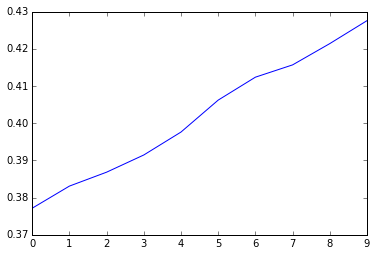

In [103]:
import matplotlib.pyplot as plt
plt.ion()
plt.plot(train_acc)

### skflow

In [115]:
!pip install http://github.com/tensorflow/skflow/archive/master.zip

    100% |████████████████████████████████| 256kB 465kB/s 


In [133]:
import tensorflow as tf
import numpy as np
import math
import tensorflow.contrib.learn as skflow
import sklearn
from sklearn import metrics
try:
    from tqdm import tqdm
except:
    def tqdm(x, *args, **kwargs):
        return x

# Seed the data
np.random.seed(0)

# Load data
data = np.load('data_with_labels.npz')
train = data['arr_0']/255.
labels = data['arr_1']

# Look at some data
print(train[0])
print(labels[0])

# If you have matplotlib installed
import matplotlib.pyplot as plt
plt.ion()

# Split data into training and validation
indices = np.random.permutation(train.shape[0])
valid_cnt = int(train.shape[0] * 0.1)
test_idx, training_idx = indices[:valid_cnt],\
                         indices[valid_cnt:]
test, train = train[test_idx,:],\
              train[training_idx,:]
test_labels, train_labels = labels[test_idx],\
                        labels[training_idx]

sess = tf.InteractiveSession()

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
0


Exception AssertionError: AssertionError("Nesting violated for default stack of <type 'weakref'> objects",) in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x1181a5a50>> ignored


In [144]:
# Logistic Regression
# steps is number of total batches
# steps/batch_size = num_epochs
classifier = skflow.TensorFlowLinearClassifier(
            n_classes=5,
            steps=1000,
            optimizer='Adam',
            learning_rate=0.01,
            continue_training=True)

# One line training
classifier.fit(train.reshape([-1,36*36]),train_labels)

# sklearn compatible accuracy
sklearn.metrics.accuracy_score(test_labels, classifier.predict(test.reshape([-1, 36*36])))

Instructions for updating:
Pass `tf.contrib.learn.infer_real_valued_columns_from_input(x)` or `tf.contrib.learn.infer_real_valued_columns_from_input_fn(input_fn)` as `feature_columns`, where `x` or `input_fn` is your argument to `fit`, `evaluate`, or `predict`.
Instructions for updating:
Pass `tf.contrib.learn.infer_real_valued_columns_from_input(x)` or `tf.contrib.learn.infer_real_valued_columns_from_input_fn(input_fn)` as `feature_columns`, where `x` or `input_fn` is your argument to `fit`, `evaluate`, or `predict`.


In [139]:
# Dense nural net
classifier = skflow.TensorFlowDNNClassifier(
            hidden_units=[10,5],
            n_classes=5,
            steps=1000,
            optimizer='Adam',
            learning_rate=0.01,
            continue_training=True)

classifier.fit(train.reshape([-1,36*36]),train_labels)

# Simple accuracy
sklearn.metrics.accuracy_score(test_labels, classifier.predict(test.reshape([-1, 36*36])))

# Confusion is easy
conf = metrics.confusion_matrix((train_labels, classifier.predict(train.reshape([-1, 36*36]))))
print(conf)

Instructions for updating:
Pass `tf.contrib.learn.infer_real_valued_columns_from_input(x)` or `tf.contrib.learn.infer_real_valued_columns_from_input_fn(input_fn)` as `feature_columns`, where `x` or `input_fn` is your argument to `fit`, `evaluate`, or `predict`.
Instructions for updating:
Pass `tf.contrib.learn.infer_real_valued_columns_from_input(x)` or `tf.contrib.learn.infer_real_valued_columns_from_input_fn(input_fn)` as `feature_columns`, where `x` or `input_fn` is your argument to `fit`, `evaluate`, or `predict`.


In [146]:
# Convolutional net
def conv_skflow(X, y):
    X = tf.reshape(X, [-1, 36, 36, 1])
    # conv layer will compute 4 features for each 5*5 patch
    with tf.variable_scope("conv_layer"):
        # 5*5 convolution, pad with zeros on edges. 
        h1 = skflow.ops.conv2d(X, n_filters=4, filter_shape=[5,5], bias=True, activation=tf.nn.relu)
        # 2*2 Max pooling, no padding on edges
        p1 = tf.nn.max_pool(h1, ksize=[1,2,2,1], strides=[1,2,2,1], padding="VALID")
        # Need to flatten conv output for use in dense layer
        p1_size = np.product([s.value for s in p1.get_shape()[1:]])
        plf = tf.reshape(p1, [-1, p1_size])
        # densely connected layer with 32 neurons and dropout
        h_fc1 = skflow.ops.dnn(plf, [32], activation=tf.nn.relu, dropout=0.5)
        return skflow.models.logistic_regression(h_fc1, y)

# Use generic estimator with our function
classifier = skflow.TensorFlowEstimator(
    model_fn = conv_skflow,
    n_classes = 5,
    steps = 1000,
    optimizer = "Adam",
    learning_rate = 0.01,
    continue_training = True)
classifier.fit(train, train_labels)

# Simple accuracy
metrics.accuracy_score(test_labels, classifier.predict(test))

# Convolutional Layer Weights
print classifier.get_tensor_value("conv_layer/convolution/filters:0")
print classifier.get_tensor_value("conv_layer/convolution/bias:0")

# Dense Layer
print classifier.get_tensor_value("dnn/layer0/Linear/Matrix:0")

# Logistic weights
print classifier.get_tensor_value("logistic_regression/weights:0")

Instructions for updating:
Please use tf.contrib.layers.conv2d instead.
Instructions for updating:
Please use tf.contrib.layers.conv2d instead.
Instructions for updating:
Please use tf.contrib.layers.stack instead.
Instructions for updating:
Please use tf.contrib.layers.stack instead.
Instructions for updating:
Please use tf.contrib.layers.dropout instead.
Instructions for updating:
Please use tf.contrib.layers.dropout instead.
Instructions for updating:
Please use tf.contrib.layers.conv2d instead.
Instructions for updating:
Please use tf.contrib.layers.conv2d instead.
Instructions for updating:
Please use tf.contrib.layers.stack instead.
Instructions for updating:
Please use tf.contrib.layers.stack instead.
Instructions for updating:
Please use tf.contrib.layers.dropout instead.
Instructions for updating:
Please use tf.contrib.layers.dropout instead.


AttributeError: 'TensorFlowEstimator' object has no attribute 'get_tensor_value'

### RNNs in skflow

In [147]:
import tensorflow as tf
import numpy as np
import datetime
import math
try:
    from tqdm import tqdm
except:
    def tqdm(x, *args, **kwargs):
        return x

# read in data
filename = "weather.npz"
data = np.load(filename)
daily = data["daily"]
weekly = data["weekly"]

num_weeks = len(weekly)
dates = np.array([datetime.datetime.strptime(str(int(d)), "%Y%m%d") for d in weekly[:,0]])

def assign_season(date):
    """Assign season based on meteorological season
       Spring - from Mar 1 to May 31
       Summer - from Jun 1 to Aug 31
       Autumn - from Sep 1 to Nov 30
       Winter - from Dec 1 to Feb 28 (Feb 29 in a leap year)
    """
    month = date.month
    # Spring = 0
    if 3 <= month < 6:
        season = 0
    # Summer = 1
    elif 6 <= month < 9:
        season = 1
    # Autumn = 2
    elif 9 <= month < 12:
        season = 2
    # Winter = 3
    elif month == 12 or month < 3:
        season = 3
    return season

# There are 4 seasons
num_classes = 4

# and 5 variables
num_inputs = 5

# and a state of 11 numbers 
state_size = 11

labels = np.zeros([num_weeks, num_classes])

# read and convert to one-hot
for i, d in enumerate(dates):
    labels[i, assign_season(d)] = 1

# extract and scale training data
train = weekly[:, 1:]
train = train - np.average(train, axis=0)
train = train / train.std(axis=0)

In [150]:
import tensorflow.contrib.learn as skflow
from sklearn import metrics

# To pass in data correctly
def listify(x):
    return [x]

# Undo the one_hot encoding
classes = [assign_season(d) for d in dates]

# one line model
classifier = skflow.TensorFlowRNNClassifier(rnn_size=11, n_classes=4, cell_type="rnn", input_op_fn=listify, num_layers=8,\
                                           steps=1000, optimizer="Adam",learning_rate=0.01, continue_training=True)

# Train model
classifier.fit(train, classes)

# Simple accuracy
metrics.accuracy_score(classes, classifier.predict(train))

# Confusion is easy in skflow
conf = metrics.confusion_matrix(classes, classifier.predict(train))
print(conf)

[[ 444   84  419  208]
 [  20 1037   94    0]
 [ 199  156  648  115]
 [  63    0   57  998]]
